In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import shutil
import os
import random
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from tqdm.auto import tqdm
from pathlib import Path
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.applications import ResNet50V2, VGG16, VGG19, MobileNetV2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_resnet50v2
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg19
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2
from tensorflow.keras.utils import to_categorical

2025-11-10 21:09:02.120691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762808942.320193      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762808942.372470      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
tf.__version__,cv2.__version__

('2.18.0', '4.12.0')

In [4]:
!python --version

Python 3.11.13


In [5]:
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(device)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [6]:
real_data = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
fake_data = '/kaggle/input/diffusiondb-2m-part-0001-to-0100-of-2000'

Found 118287 images in folder
Selected 16 images to display


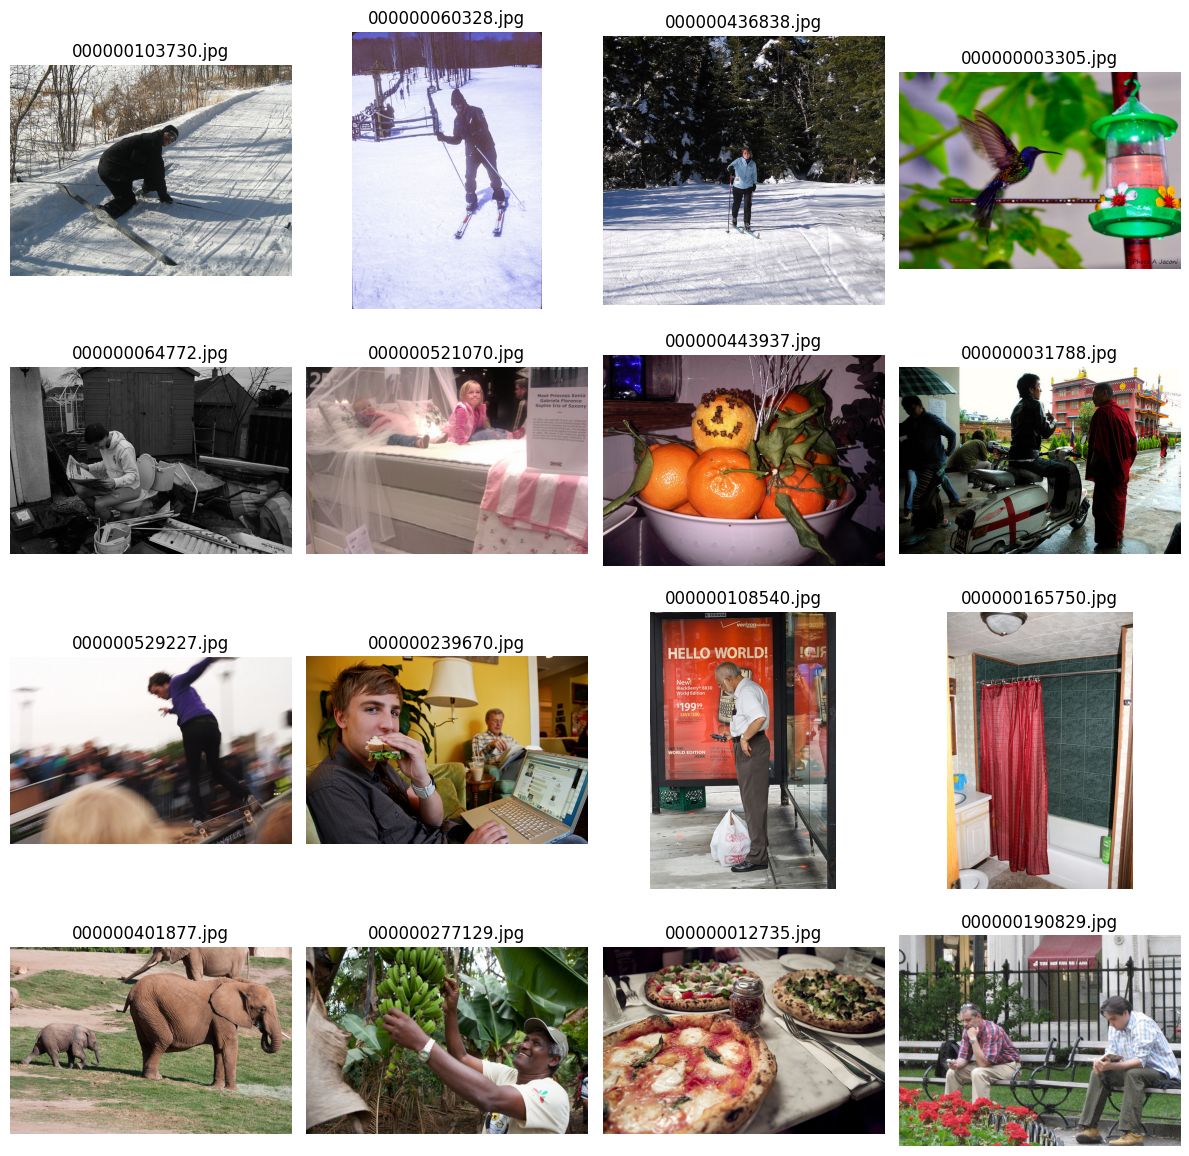

In [7]:
main_folder = r'/kaggle/input/coco-2017-dataset/coco2017/train2017'


all_images = [os.path.join(main_folder, img) for img in os.listdir(main_folder) 
              if img.endswith(('.jpg', '.png', '.webp', '.jpeg'))]

# Randomly select 16 images
random.shuffle(all_images)
selected_images = all_images[:16]

print(f"Found {len(all_images)} images in folder")
print(f"Selected {len(selected_images)} images to display")

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load: {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(img_path)[:20])  # Show filename (truncated)

plt.tight_layout()
plt.show()

Found 100000 images in folder
Selected 16 images to display


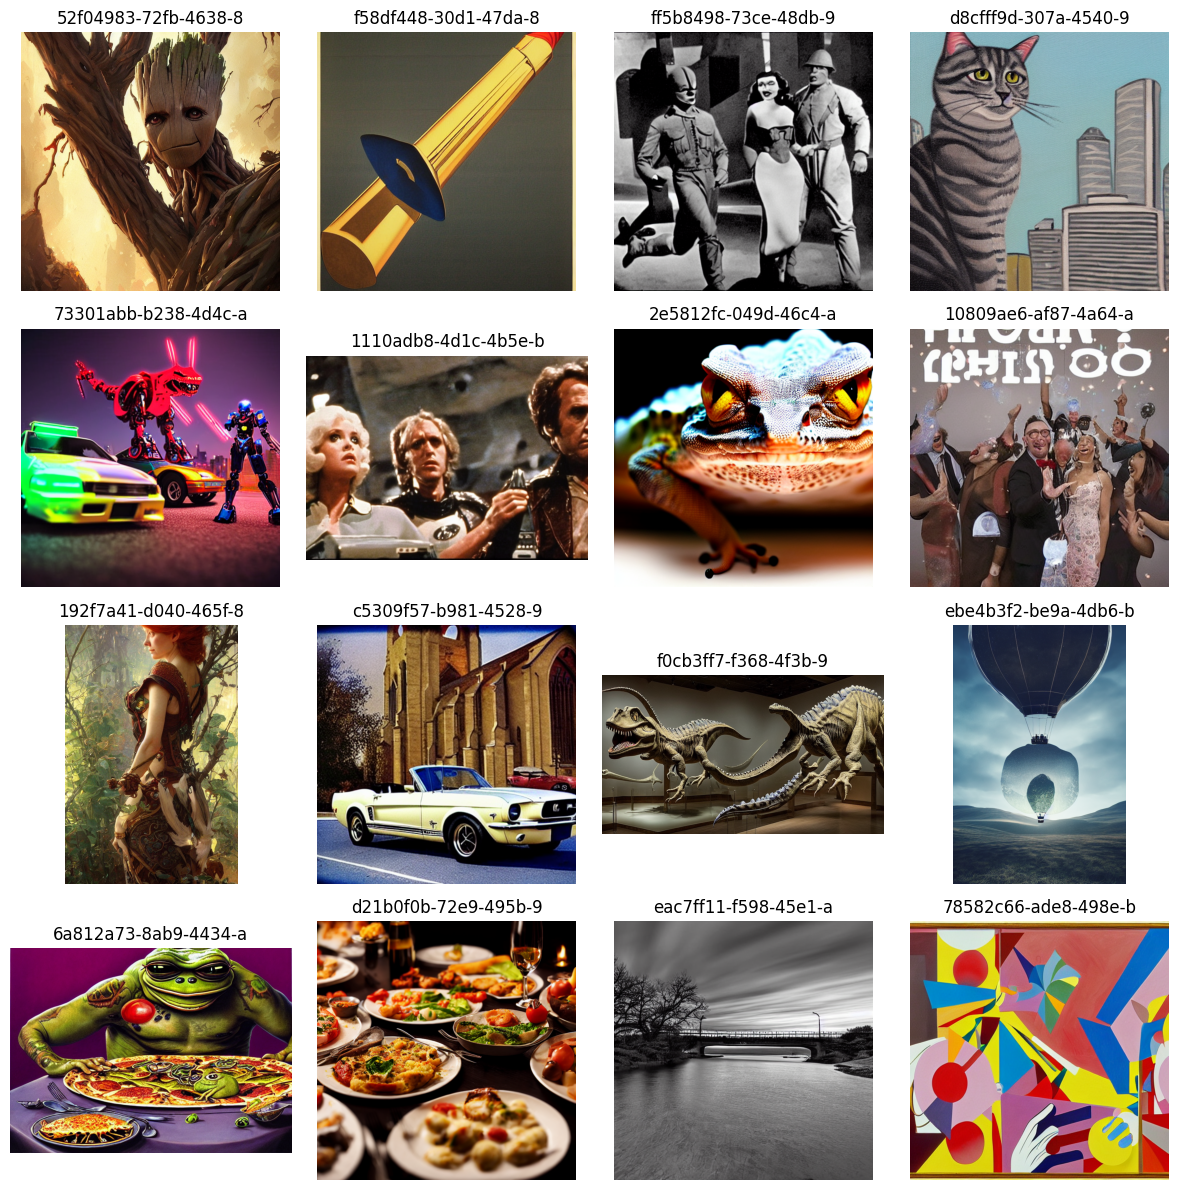

In [8]:
main_folder = r'/kaggle/input/diffusiondb-2m-part-0001-to-0100-of-2000'


all_images = [os.path.join(main_folder, img) for img in os.listdir(main_folder) 
              if img.endswith(('.jpg', '.png', '.webp', '.jpeg'))]

# Randomly select 16 images
random.shuffle(all_images)
selected_images = all_images[:16]

print(f"Found {len(all_images)} images in folder")
print(f"Selected {len(selected_images)} images to display")

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load: {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(img_path)[:20])  # Show filename (truncated)

plt.tight_layout()
plt.show()

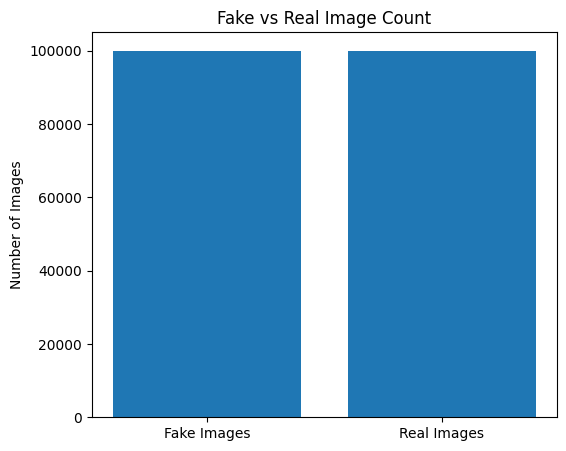

In [9]:
main_folder_fake = r'/kaggle/input/diffusiondb-2m-part-0001-to-0100-of-2000'


all_images_fake = [os.path.join(main_folder, img) for img in os.listdir(main_folder) 
              if img.endswith(('.jpg', '.png', '.webp', '.jpeg'))]
len(all_images_fake)

main_folder_real = r'/kaggle/input/coco-2017-dataset/coco2017/train2017'


all_images_real = [os.path.join(main_folder, img) for img in os.listdir(main_folder) 
              if img.endswith(('.jpg', '.png', '.webp', '.jpeg'))]
len(all_images_real)

counts = [len(all_images_fake), len(all_images_real)]
labels = ['Fake Images', 'Real Images']

plt.figure(figsize=(6, 5))
plt.bar(labels, counts)
plt.ylabel('Number of Images')
plt.title('Fake vs Real Image Count')
plt.show()

In [10]:
len(all_images_fake)

100000

In [11]:
len(all_images_real)

100000

In [12]:
import os
import random
from pathlib import Path

# Configuration
CLASS0_DIR = r"/kaggle/input/diffusiondb-2m-part-0001-to-0100-of-2000"
CLASS1_DIR = r"/kaggle/input/coco-2017-dataset/coco2017/train2017"
OUTPUT_DIR = r"/kaggle/working/"

random.seed(42)

# Get all images
class0_imgs = list(Path(CLASS0_DIR).glob('*.*'))
class1_imgs = list(Path(CLASS1_DIR).glob('*.*'))

random.shuffle(class0_imgs)
random.shuffle(class1_imgs)

# Split indices
splits = {
    'train': (0, 70000),
    'val': (70000, 85000),
    'test': (85000, 100000)
}

# Create symlinks
for split, (start, end) in splits.items():
    for cls, images in [('fake', class0_imgs), ('real', class1_imgs)]:
        out_dir = Path(OUTPUT_DIR) / split / cls
        out_dir.mkdir(parents=True, exist_ok=True)
        
        for img in images[start:end]:
            (out_dir / img.name).symlink_to(img.absolute())
        
        print(f"{split}/{cls}: {end-start} images")

print("Done!")

train/fake: 70000 images
train/real: 70000 images
val/fake: 15000 images
val/real: 15000 images
test/fake: 15000 images
test/real: 15000 images
Done!


In [13]:
train_path = '/kaggle/working/train'
valid_path = '/kaggle/working/val'
test_path = '/kaggle/working/test'

In [14]:
IMAGE_SIZE = 224

BATCH_SIZE = 32

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=True,
    seed=123
)

Found 140000 files belonging to 2 classes.


I0000 00:00:1762809188.692957      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762809188.693691      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [16]:
train_ds.class_names

['fake', 'real']

In [17]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

Found 30000 files belonging to 2 classes.


In [18]:
valid_ds.class_names

['fake', 'real']

In [19]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

Found 30000 files belonging to 2 classes.


In [20]:
test_ds.class_names

['fake', 'real']

In [21]:
normalization = tf.keras.layers.Rescaling(1./255)


def prepare_data(x, y):
    x = normalization(x)
    return x, y

train_ds = train_ds.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE)


train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [22]:
trained_ResNet_layers = ResNet50V2(weights='imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
for layer in trained_ResNet_layers.layers:
    layer.trainable = False

In [24]:
ResNet_model = keras.models.Sequential([
    trained_ResNet_layers,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation='relu'),  
    BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),  
    BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

In [25]:
ResNet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,123,905 (92.03 MB)

 Trainable params: 558,337 (2.13 MB)

 Non-trainable params: 23,565,568 (89.90 MB)

In [26]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='ResNet_best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

In [27]:
ResNet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

In [28]:
ResNet_history = ResNet_model.fit(
    train_ds,
    epochs=20,
    validation_data=valid_ds,
    callbacks=callbacks
)

Epoch 1/20


I0000 00:00:1762809289.638675      76 service.cc:148] XLA service 0x7ed6c0002bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762809289.639320      76 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762809289.639346      76 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762809291.727639      76 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/4375 ━━━━━━━━━━━━━━━━━━━━ 6:19 87ms/step - accuracy: 0.3984 - auc: 0.3688 - loss: 1.1256 - precision: 0.3328 - recall: 0.4245   

I0000 00:00:1762809299.755910      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8552 - auc: 0.9271 - loss: 0.3397 - precision: 0.8467 - recall: 0.8675
Epoch 1: val_loss improved from inf to 0.17052, saving model to ResNet_best_model.keras
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 856s 191ms/step - accuracy: 0.8552 - auc: 0.9271 - loss: 0.3397 - precision: 0.8467 - recall: 0.8675 - val_accuracy: 0.9322 - val_auc: 0.9821 - val_loss: 0.1705 - val_precision: 0.9287 - val_recall: 0.9362 - learning_rate: 1.0000e-04
Epoch 2/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9194 - auc: 0.9737 - loss: 0.2054 - precision: 0.9141 - recall: 0.9257
Epoch 2: val_loss improved from 0.17052 to 0.15468, saving model to ResNet_best_model.keras
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 780s 178ms/step - accuracy: 0.9194 - auc: 0.9737 - loss: 0.2054 - precision: 0.9141 - recall: 0.9257 - val_accuracy: 0.9386 - val_auc: 0.9851 - val_loss: 0.1547 - val_precision: 0.9327 - val_recall: 0.9453 - learning_rate: 1.0000e-04
Epoch 3/20
4375/437

In [29]:
!nvidia-smi

Tue Nov 11 00:22:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             31W /   70W |   14065MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [30]:
ResNet_model.load_weights("/kaggle/working/ResNet_best_model.keras")
print("Loaded saved weights successfully")

Loaded saved weights successfully


In [31]:
initial_epoch = 15  
ResNet_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=20,               
    initial_epoch=initial_epoch,
    callbacks= callbacks
)

Epoch 16/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9569 - auc: 0.9913 - loss: 0.1155 - precision: 0.9548 - recall: 0.9592
Epoch 16: val_loss did not improve from 0.12566
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 779s 178ms/step - accuracy: 0.9569 - auc: 0.9913 - loss: 0.1155 - precision: 0.9548 - recall: 0.9592 - val_accuracy: 0.9522 - val_auc: 0.9896 - val_loss: 0.1274 - val_precision: 0.9500 - val_recall: 0.9546 - learning_rate: 1.0000e-04
Epoch 17/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9577 - auc: 0.9920 - loss: 0.1103 - precision: 0.9553 - recall: 0.9602
Epoch 17: val_loss did not improve from 0.12566
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 722s 165ms/step - accuracy: 0.9577 - auc: 0.9920 - loss: 0.1103 - precision: 0.9553 - recall: 0.9602 - val_accuracy: 0.9539 - val_auc: 0.9895 - val_loss: 0.1272 - val_precision: 0.9555 - val_recall: 0.9523 - learning_rate: 1.0000e-04
Epoch 18/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9593 - auc: 0.9922 

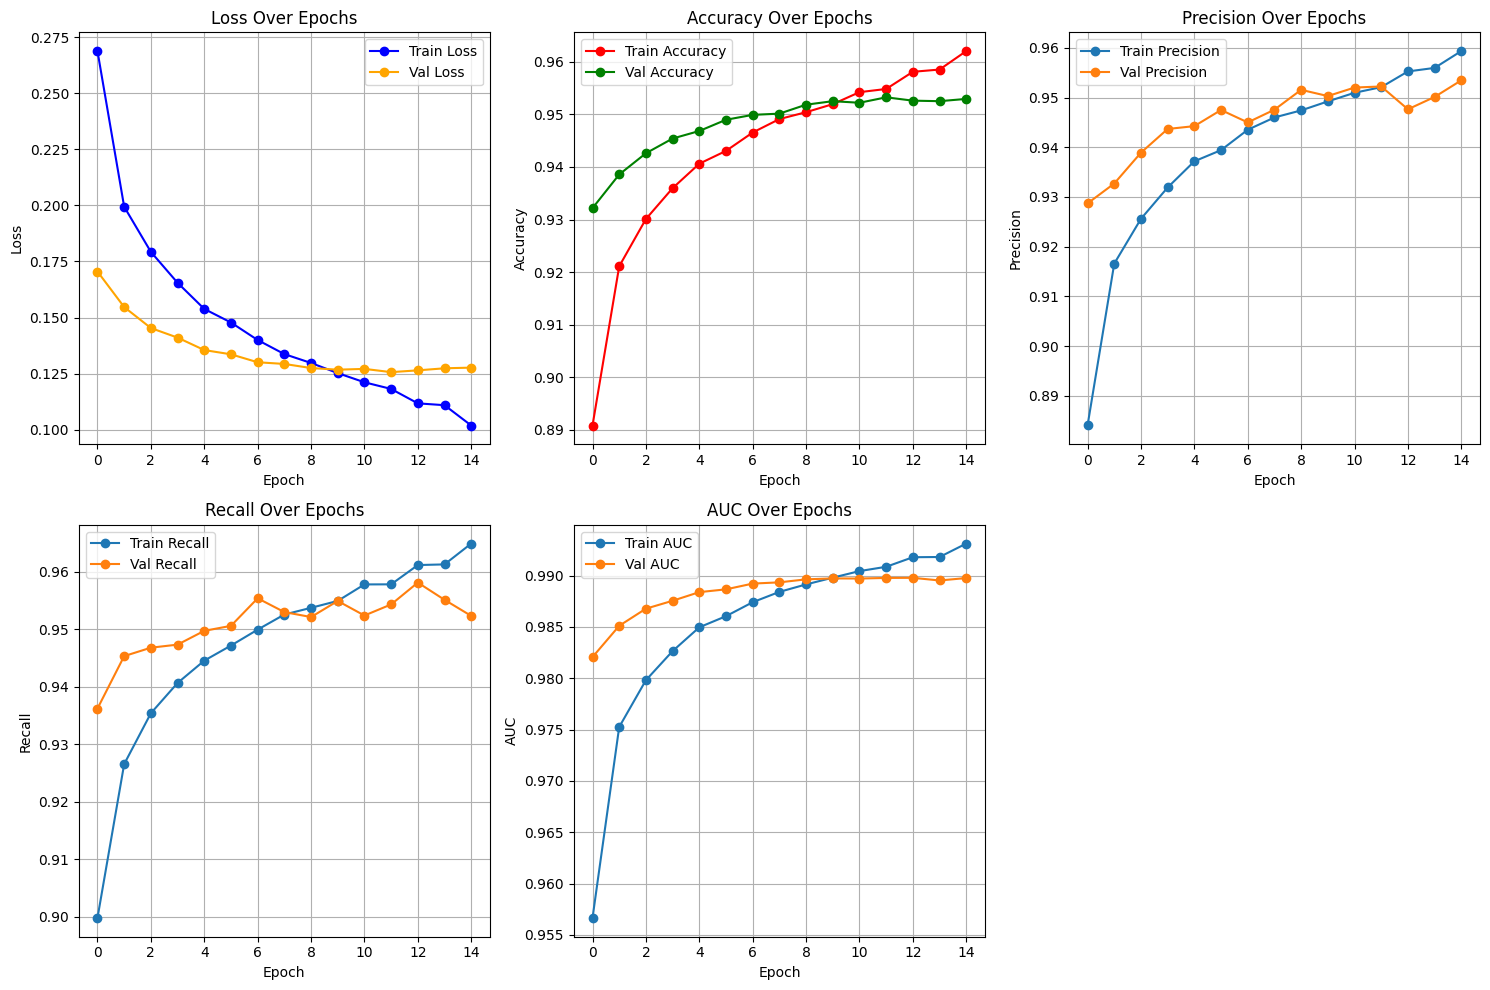

In [32]:
plt.figure(figsize=(15, 10))

# Loss
plt.subplot(2, 3, 1)
plt.plot(ResNet_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(ResNet_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(2, 3, 2)
plt.plot(ResNet_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(ResNet_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 3, 3)
plt.plot(ResNet_history.history['precision'], label='Train Precision', marker='o')
plt.plot(ResNet_history.history['val_precision'], label='Val Precision', marker='o')
plt.title('Precision Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 3, 4)
plt.plot(ResNet_history.history['recall'], label='Train Recall', marker='o')
plt.plot(ResNet_history.history['val_recall'], label='Val Recall', marker='o')
plt.title('Recall Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# AUC
plt.subplot(2, 3, 5)
plt.plot(ResNet_history.history['auc'], label='Train AUC', marker='o')
plt.plot(ResNet_history.history['val_auc'], label='Val AUC', marker='o')
plt.title('AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [33]:
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

resnet_result = ResNet_model.evaluate(test_ds, batch_size=BATCH_SIZE)
print(f"\nTest Loss: {resnet_result[0]:.4f}")
print(f"Test Accuracy: {resnet_result[1]:.4f}")
print(f"Test Precision: {resnet_result[2]:.4f}")
print(f"Test Recall: {resnet_result[3]:.4f}")
print(f"Test AUC: {resnet_result[4]:.4f}")


EVALUATING ON TEST SET
938/938 ━━━━━━━━━━━━━━━━━━━━ 155s 165ms/step - accuracy: 0.9531 - auc: 0.4968 - loss: 0.1241 - precision: 0.4263 - recall: 0.4785

Test Loss: 0.1222
Test Accuracy: 0.9543
Test Precision: 0.9534
Test Recall: 0.9553
Test AUC: 0.9903


In [34]:
resnet_predictions = ResNet_model.predict(test_ds)
y_pred_binary = (resnet_predictions > 0.5).astype(int).flatten()

# Get true labels
y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true).astype(int)

# Ensure same length (in case of remainder batch)
min_len = min(len(y_true), len(y_pred_binary))
y_true = y_true[:min_len]
y_pred_binary = y_pred_binary[:min_len]

938/938 ━━━━━━━━━━━━━━━━━━━━ 111s 112ms/step


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred_binary))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     15000
           1       0.95      0.96      0.95     15000

    accuracy                           0.95     30000
   macro avg       0.95      0.95      0.95     30000
weighted avg       0.95      0.95      0.95     30000



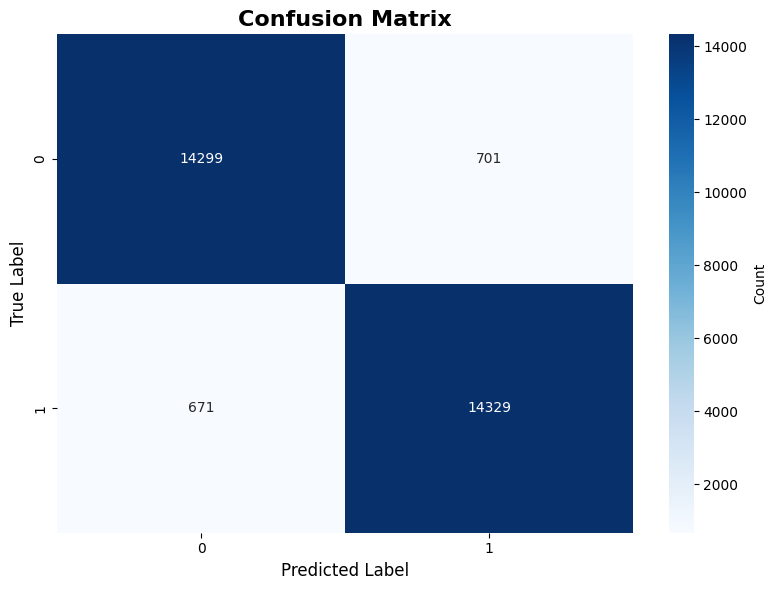

In [36]:
cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [37]:
# Additional metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print("\n" + "="*60)
print("CONFUSION MATRIX BREAKDOWN")
print("="*60)
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")
print(f"\nSpecificity: {tn/(tn+fp):.4f}")
print(f"Sensitivity (Recall): {tp/(tp+fn):.4f}")
print(f"F1-Score: {2*tp/(2*tp+fp+fn):.4f}")


CONFUSION MATRIX BREAKDOWN
True Negatives:  14299
False Positives: 701
False Negatives: 671
True Positives:  14329

Specificity: 0.9533
Sensitivity (Recall): 0.9553
F1-Score: 0.9543
